In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:

import opendatasets as od

In [3]:

dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [4]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [5]:

od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Ravikesh
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


100%|██████████| 225M/225M [00:03<00:00, 68.5MB/s]


In [6]:
data_dir = './flowers-recognition/flowers'

In [7]:

import os

In [8]:

os.listdir(data_dir)

['rose', 'sunflower', 'tulip', 'daisy', 'dandelion']

In [9]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

rose : 784
sunflower : 733
tulip : 984
daisy : 764
dandelion : 1052


In [10]:
from torchvision.datasets import ImageFolder

In [11]:
dataset = ImageFolder(data_dir)

In [12]:

len(dataset)

4317

In [13]:

dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [14]:

dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

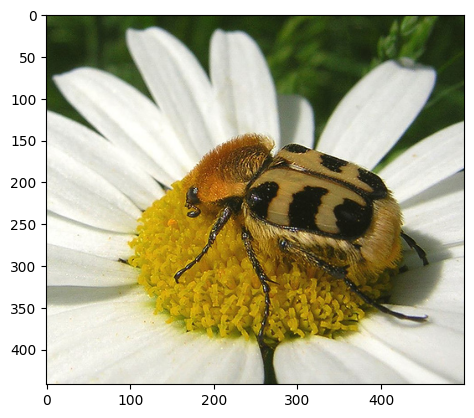

In [16]:
img, label = dataset[120]
plt.imshow(img)

In [17]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

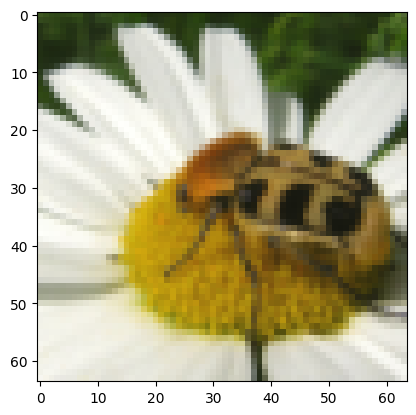

In [18]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [19]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [20]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])

len(train_ds) , len(valid_ds)

(3886, 431)

In [21]:
from torch.utils.data import DataLoader

batch_size= 132

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      num_workers= 2,
                    pin_memory = True)

valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers= 2,
                    pin_memory = True)

In [22]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow =16).permute(1, 2, 0))
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


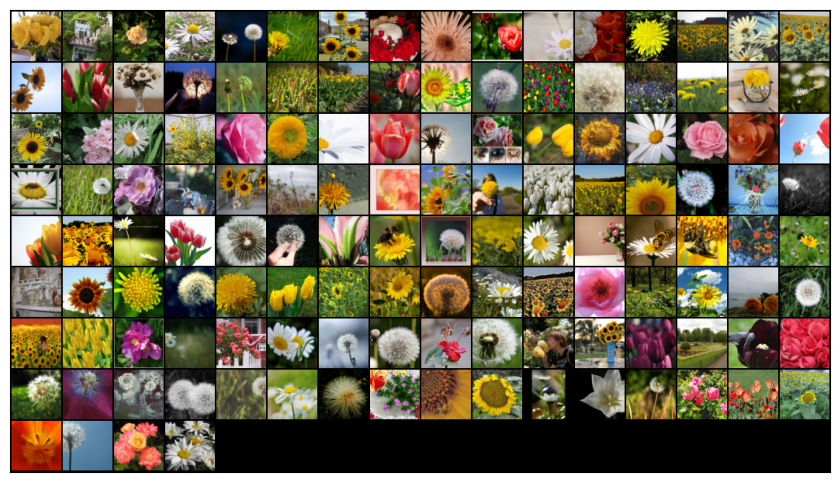

In [23]:

show_batch(train_dl)

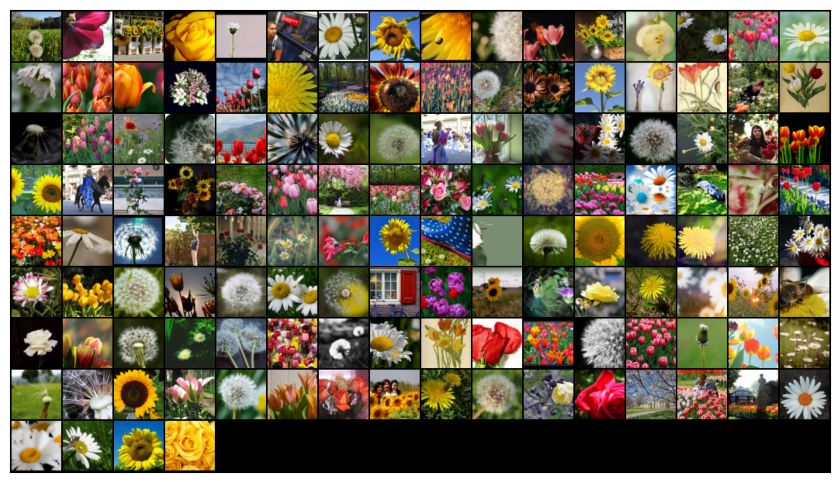

In [24]:

show_batch(valid_dl)

In [25]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:

torch.cuda.is_available()

True

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:

img, label = dataset[0]

In [29]:
img.device

device(type='cpu')

In [30]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [33]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [62]:
def _approximated_ReLU(x):
    return 0.117071 * x**2 + 0.5 * x + 0.375373

class Square(torch.nn.Module):
    def forward(self, x):
        return x**2

class ApproxReLU(torch.nn.Module):
    def forward(self, x):
        return _approximated_ReLU(x)

class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

In [61]:
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding= 1),
            nn.BatchNorm2d(out_channels),
            ApproxReLU()]

  if pool: layers.append(nn.AvgPool2d(kernel_size=2))
  return nn.Sequential(*layers)



# class ResNet9(ImageClassificationBase):
#   def __init__(self, in_channels, num_classes):
#     super().__init__()

#     self.conv1 = conv_block(in_channels, 64)
#     self.conv2 = conv_block(64, 128, pool=True)
#     self.res1 = nn.Sequential(conv_block(128, 128),
#                               conv_block(128, 128))

#     self.conv3 = conv_block(128, 256, pool=True)
#     self.conv4 = conv_block(256, 512, pool=True)
#     self.res2 = nn.Sequential(conv_block(512, 512),
#                               conv_block(512, 512))

#     self.classifier = nn.Sequential(nn.AvgPool2d(kernel_size=2),
#                                     nn.Flatten(),
#                                     nn.Dropout(0.2),
#                                     nn.Linear(512, num_classes)
#                                     )

#   def forward(self, xb):
#     out = self.conv1(xb)
#     out = self.conv2(out)
#     out = self.res1(out) + out
#     out = self.conv3(out)
#     out = self.conv4(out)
#     out = self.res2(out) + out
#     out =self.classifier(out)
#     return(out)
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128),
                                  conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512),
                                  conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes)  # Fixed output size
                                        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Create the model with the correct number of classes
model = ResNet9(3, len(dataset.classes))


In [49]:
# import torch.nn as nn

# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, pool=False):
#         super(ConvBlock, self).__init__()

#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
#         self.batch_norm = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)

#         self.pool = None
#         if pool:
#             self.pool = nn.MaxPool2d(2)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.batch_norm(x)
#         x = self.relu(x)
#         if self.pool:
#             x = self.pool(x)
#         return x


# class ResNet9(ImageClassificationBase):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()

#         self.conv1 = ConvBlock(in_channels, 64)
#         self.conv2 = ConvBlock(64, 128, pool=True)
#         self.res1_conv1 = ConvBlock(128, 128)
#         self.res1_conv2 = ConvBlock(128, 128)

#         self.conv3 = ConvBlock(128, 256, pool=True)
#         self.conv4 = ConvBlock(256, 512, pool=True)
#         self.res2_conv1 = ConvBlock(512, 512)
#         self.res2_conv2 = ConvBlock(512, 512)

#         self.classifier_pool = nn.AdaptiveMaxPool2d(1)
#         self.classifier_flatten = nn.Flatten()
#         self.classifier_dropout = nn.Dropout(0.2)
#         self.classifier_linear = nn.Linear(512, num_classes)

#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)

#         # Residual block 1
#         residual = out
#         out = self.res1_conv1(out)
#         out = self.res1_conv2(out)
#         out += residual

#         out = self.conv3(out)
#         out = self.conv4(out)

#         # Residual block 2
#         residual = out
#         out = self.res2_conv1(out)
#         out = self.res2_conv2(out)
#         out += residual

#         out = self.classifier_pool(out)
#         out = self.classifier_flatten(out)
#         out = self.classifier_dropout(out)
#         out = self.classifier_linear(out)

#         return out

# import torch.nn as nn

# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, pool=False):
#         super(ConvBlock, self).__init__()

#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
#         self.batch_norm = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=False)  # Set inplace to False

#         self.pool = None
#         if pool:
#             self.pool = nn.MaxPool2d(2)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.batch_norm(x)
#         x = self.relu(x)
#         if self.pool:
#             x = self.pool(x)
#         return x


# class ResNet9(ImageClassificationBase):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()

#         self.conv1 = ConvBlock(in_channels, 64)
#         self.conv2 = ConvBlock(64, 128, pool=True)
#         self.res1_conv1 = ConvBlock(128, 128)
#         self.res1_conv2 = ConvBlock(128, 128)

#         self.conv3 = ConvBlock(128, 256, pool=True)
#         self.conv4 = ConvBlock(256, 512, pool=True)
#         self.res2_conv1 = ConvBlock(512, 512)
#         self.res2_conv2 = ConvBlock(512, 512)

#         self.classifier_pool = nn.AdaptiveMaxPool2d(1)
#         self.classifier_flatten = nn.Flatten()
#         self.classifier_dropout = nn.Dropout(0.2)
#         self.classifier_linear = nn.Linear(512, num_classes)

#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)

#         # Residual block 1
#         residual = out
#         out = self.res1_conv1(out)
#         out = self.res1_conv2(out)
#         out += residual

#         out = self.conv3(out)
#         out = self.conv4(out)

#         # Residual block 2
#         residual = out
#         out = self.res2_conv1(out)
#         out = self.res2_conv2(out)
#         out += residual

#         out = self.classifier_pool(out)
#         out = self.classifier_flatten(out)
#         out = self.classifier_dropout(out)
#         out = self.classifier_linear(out)

#         return out





In [63]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ApproxReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ApproxReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ApproxReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ApproxReLU()
    )
  )
  (conv3): Sequential(
    (0): Conv2d(

In [64]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape' , preds.shape)
  break

images.shape torch.Size([132, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([132, 5])


In [65]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6263587474822998, 'val_acc': 0.21812769770622253}]

In [83]:
# torch.autograd.set_detect_anomaly(True)

In [66]:
import torch

# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)


In [67]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 3.1675, val_loss: 1.3930, val_acc: 0.3707
Epoch [1], train_loss: 1.8598, val_loss: 1.2308, val_acc: 0.4419
Epoch [2], train_loss: 1.3574, val_loss: 1.1745, val_acc: 0.5088
Epoch [3], train_loss: 1.2549, val_loss: 1.0915, val_acc: 0.5415
Epoch [4], train_loss: 1.1502, val_loss: 1.0648, val_acc: 0.5965


In [68]:

history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.0637, val_loss: 1.0101, val_acc: 0.5932
Epoch [1], train_loss: 0.9959, val_loss: 0.9378, val_acc: 0.6401
Epoch [2], train_loss: 0.9611, val_loss: 0.9468, val_acc: 0.6311
Epoch [3], train_loss: 0.9174, val_loss: 0.9129, val_acc: 0.6367
Epoch [4], train_loss: 0.8931, val_loss: 0.9225, val_acc: 0.6695


In [69]:

history += fit(5, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8464, val_loss: 0.8898, val_acc: 0.6643
Epoch [1], train_loss: 0.8401, val_loss: 0.8772, val_acc: 0.6756
Epoch [2], train_loss: 0.8250, val_loss: 0.8831, val_acc: 0.6466
Epoch [3], train_loss: 0.8328, val_loss: 0.8675, val_acc: 0.6557
Epoch [4], train_loss: 0.8066, val_loss: 0.8765, val_acc: 0.6528


In [70]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8635, val_loss: 0.8909, val_acc: 0.6595
Epoch [1], train_loss: 0.8248, val_loss: 0.8851, val_acc: 0.6595
Epoch [2], train_loss: 0.8027, val_loss: 0.8748, val_acc: 0.6519
Epoch [3], train_loss: 0.7768, val_loss: 0.8808, val_acc: 0.6719
Epoch [4], train_loss: 0.7569, val_loss: 0.8362, val_acc: 0.6784


In [71]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

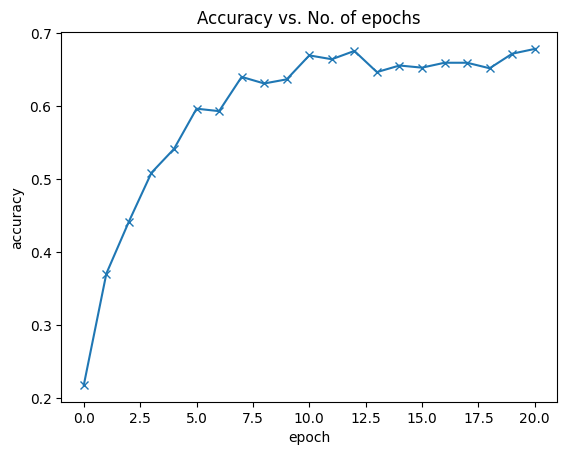

In [72]:
plot_accuracies(history)

In [73]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

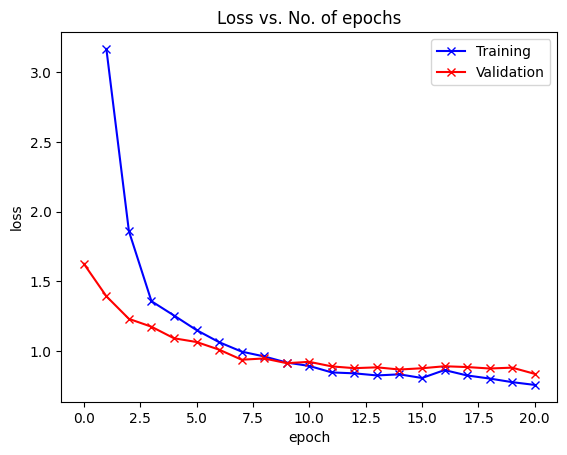

In [74]:
plot_losses(history)

In [75]:
history[-1]


{'val_loss': 0.8362125158309937,
 'val_acc': 0.6784090995788574,
 'train_loss': 0.7569249868392944}

In [76]:
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding= 1),
            nn.BatchNorm2d(out_channels),
            ApproxReLU()]

  if pool: layers.append(nn.AvgPool2d(kernel_size=2))
  return nn.Sequential(*layers)


class ResNet9_approx(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128),
                                  conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512),
                                  conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AvgPool2d(kernel_size=1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes)  # Fixed output size
                                        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Create the model with the correct number of classes
model = ResNet9_approx(3, len(dataset.classes))

In [77]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ApproxReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ApproxReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ApproxReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ApproxReLU()
    )
  )
  (conv3): Sequential(
    (0): Conv2d(

In [78]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape' , preds.shape)
  break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


images.shape torch.Size([132, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([132, 5])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [79]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6948721408843994, 'val_acc': 0.26082250475883484}]

In [80]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.8758, val_loss: 1.3857, val_acc: 0.3746
Epoch [1], train_loss: 1.2574, val_loss: 1.1339, val_acc: 0.5587
Epoch [2], train_loss: 1.1410, val_loss: 1.0301, val_acc: 0.5837
Epoch [3], train_loss: 1.0860, val_loss: 1.0331, val_acc: 0.5631
Epoch [4], train_loss: 0.9868, val_loss: 1.2028, val_acc: 0.5415


In [81]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.9224, val_loss: 0.9103, val_acc: 0.6552
Epoch [1], train_loss: 0.8695, val_loss: 0.8961, val_acc: 0.6466
Epoch [2], train_loss: 0.8456, val_loss: 0.9111, val_acc: 0.6386
Epoch [3], train_loss: 0.8089, val_loss: 0.8346, val_acc: 0.6946
Epoch [4], train_loss: 0.7769, val_loss: 0.8771, val_acc: 0.6584


In [82]:
history += fit(5, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.7667, val_loss: 0.8251, val_acc: 0.6851
Epoch [1], train_loss: 0.7355, val_loss: 0.8133, val_acc: 0.6950
Epoch [2], train_loss: 0.7359, val_loss: 0.8285, val_acc: 0.6818
Epoch [3], train_loss: 0.7300, val_loss: 0.8151, val_acc: 0.6870
Epoch [4], train_loss: 0.7203, val_loss: 0.8105, val_acc: 0.6950


In [83]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.7915, val_loss: 0.8227, val_acc: 0.6813
Epoch [1], train_loss: 0.7481, val_loss: 0.8335, val_acc: 0.6984
Epoch [2], train_loss: 0.7239, val_loss: 0.8373, val_acc: 0.6832
Epoch [3], train_loss: 0.6980, val_loss: 0.8107, val_acc: 0.7116
Epoch [4], train_loss: 0.6808, val_loss: 0.8584, val_acc: 0.6946


In [84]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

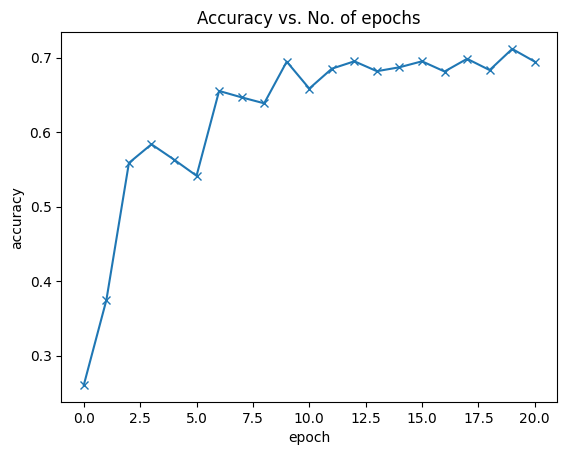

In [85]:
plot_accuracies(history)

In [86]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

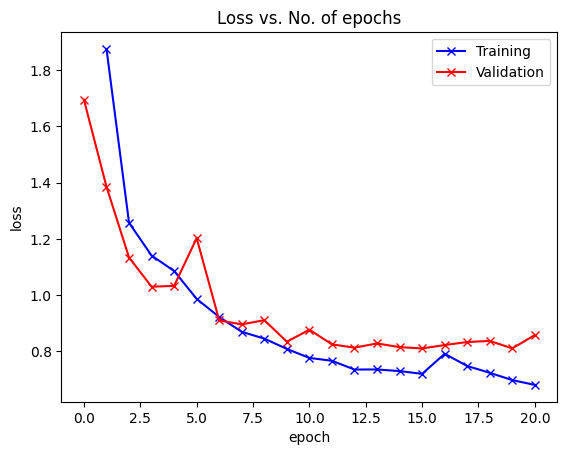

In [87]:
plot_losses(history)

In [88]:
history[-1]

{'val_loss': 0.8583537340164185,
 'val_acc': 0.6945887804031372,
 'train_loss': 0.6808375120162964}